# Stanify - Bridging Vensim Models into Stan

This notebook gives a gentle introduction on utilizing the stanify module to translate Vensim models into a fully fledged Stan program and perform Simulation-Based Calibration.

We start by introducing the ODE model.

(Insert short introduction on Vensim here)

## The Lotka-Volterra Model

The model we'll be using will be the Lotka-Volterra equations, informally known as the predator-prey model. There are two equations that govern the rate of population change through two equations:

$$
\begin{aligned}
\frac{dy_{prey}}{dt} &= \alpha y_{prey} - \beta y_{pred} y_{prey} \\
\frac{dy_{pred}}{dt} &= \delta y_{prey} y_{pred} - \gamma y_{pred} \\
\end{aligned}
$$

The hyperparameter $\alpha$ denote the prey reproduction rate, $\beta$ the prey death rate, $\delta$ the predator reproduction rate, and $\gamma$ the predator death rate.

## A Hierarchical Version

Suppose we observed data for two different regions, and we wish to model them within a hierarchical model. We equip the standard predator-prey equations with subscripts, which indicate that the variables are present for each region:

$$
\begin{aligned}
\frac{{dy_{prey}}_{region}}{dt} &= \alpha_{region} {y_{prey}}_{region} - \beta_{region} {y_{pred}}_{region} {y_{prey}}_{region} \\
\frac{{dy_{pred}}_{region}}{dt} &= \delta_{region} {y_{prey}}_{region} {y_{pred}}_{region} - {\gamma}_{region} {y_{pred}}_{region} \\
\end{aligned}
$$

## An Introduction to the V2S Syntax

Once we have the mathematical model set in stone, we'll use the Vensim2Stan feature of stanify to translate the model into a Stan program.

Stan provides an ODE solver interface, which allows integrating a set of differential equations. Stanify will take a given Vensim model(the predator-prey model in our case), and will convert it into a `functions.stan` file which holds the ODE function that may be used with Stan's ODE solver.

However, the differential equations are not the only component of a Stan program. Suppose the observed population data contain some measurement error and normally distributed. We can then construct a model like the following:

$$
\begin{aligned}
{y^{obs}_{prey}}_{region} &\sim \mathrm{normal}({y_{prey}}_{region}, \sigma) \\
\sigma &\sim \mathrm{lognormal}(-1, 1)
\end{aligned}
$$

The V2S syntax in Stanify is used to describe priors and setting up likelihoods. The code for the above model would be written in V2S like the following:

```
prey_obs[region, timesteps] ~ normal(prey[region, timesteps], sigma);
sigma<lower=0.1> ~ lognormal(-1, 1);
```

Let's pick this code apart piece by piece:

```
prey_obs[region, timesteps] ~ normal(prey[region, timesteps], sigma);
```

Here we've declared that a parameter `prey_obs` follows a normal distribution with mean parameter `prey` and SD `sigma`. There's a special form of syntax here, next to the prey variables:

```
prey_obs[region, timesteps]
```

At a first glance, this seeems like an indexing operation. But in V2S, it has a little different meaning. Much like Vensim subscripts, his declares that the variable `prey_obs` exists for each region, timestep pair.

Note that `region` was declared within Vensim. But `timesteps` is a special subscript that can only be used for stock variables. It indicates the value at a given timestep.

We can then interpret the above line as the following:

> Variable prey_obs exists for each region-timstep combination, and follows a normal distribution with mean value of stock variable prey at the given region-timestep and a shared standard deviation parameter sigma.

The final line,

```
sigma<lower=0.1> ~ lognormal(-1, 1);
```

Is straightforward. It declares a single parameter `sigma` that's lower bounded and follows a log-normal distribution. The syntax for defining lower/upper bounds are the same as with stan and must come before the subscript operation(brackets).

We can now try and run SBC for the given Vensim model-V2S code combination.

In [104]:
import sys
sys.path.append("/Users/dashadower/git_repos/stanify")

In [32]:
from stanify.builders.vensim2stan import Vensim2Stan
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt

We find the path to the Vensim model that holds the hierarchical LV model:

In [102]:
vensim_model_path = "/Users/dashadower/git_repos/stanify/vensim_models/hier_prey_predator_wopnoise.mdl"

We write out the V2S code that describes the observation model and priors:

In [5]:
v2s_code = """
prey_obs[region, timesteps] ~ normal(prey[region, timesteps], sigma);
sigma<lower=0.1> ~ lognormal(-1, 1);
"""

`Vensim2Stan` is the main interface of the Stanify package. We'll be using this class to create the stan files and run SBC. We need to pass the V2S code we've written, the path to the Vensim model, the initial time for the ODE system, and the integration timesteps:

In [6]:
v2s = Vensim2Stan(v2s_code, vensim_model_path, "prey_obs", initial_time=0, integration_times=list(range(1, 51)))

In [7]:
%%capture
sbc_idata = v2s.run_sbc(n_data_sets=200, n_post_draws=2000, n_chains=4, overwrite=True);

The fits are returned in an `arviz.InferenceData` format, which allows convenient plotting and manipulation.

In [10]:
sbc_idata

Inference data with groups:
	> posterior
	> prior
	> prior_predictive
	> sample_stats_prior

Upon inspection of the `InferenceData`, we can see that there's an additional named dimension named `prior_draw` of length 200. This indicates the dataset index.

Also note that the variables we declared in V2S to have subscripts, `prey_obs` and `prey`, along with the other stock variable `predator`, are equipped with additional named dimensions `region` and `timesteps`.

## Plotting SBC results

The simplest form of SBC plots is the rank plot. It's very straightforward to implement. For demonstration, we'll use the parameter `sigma`.

In [23]:
sbc_idata.posterior.sigma.isel(prior_draw=0)

<xarray.DataArray 'sigma' (posterior_draw: 2000)>
array([0.327601, 0.226395, 0.241192, ..., 0.253391, 0.248076, 0.252668])
Coordinates:
    chain    (posterior_draw) int64 0 0 0 0 0 0 0 0 0 0 ... 3 3 3 3 3 3 3 3 3 3
    draw     (posterior_draw) int64 0 1 2 3 4 5 6 ... 494 495 496 497 498 499
Dimensions without coordinates: posterior_draw

We calculate the standard rank statistic and a fractional ranks which are ranks scaled to the range $[0, 1]$.
During calculation, note that we vectorize along the `prior_draw` dimension, which simplifies calculation.

In [111]:
sbc_idata.prior["sigma"].isel(prior_draw=1)

<xarray.DataArray 'sigma' ()>
array(1.34922)
Coordinates:
    chain    int64 0
    draw     int64 1

In [63]:
def calculate_ranks(theta_xr, post_theta_xr):
    return np.sum(theta_xr > post_theta_xr)

def calculate_fractional_ranks(theta_xr, post_theta_xr):
    return (1 + np.sum(theta_xr > post_theta_xr)) / (1 + 2000)

ranks = xr.apply_ufunc(calculate_ranks, sbc_idata.prior.sigma, sbc_idata.posterior.sigma, input_core_dims=[[], ["posterior_draw"]], vectorize=True)

fractional_ranks = xr.apply_ufunc(calculate_fractional_ranks, sbc_idata.prior.sigma, sbc_idata.posterior.sigma, input_core_dims=[[], ["posterior_draw"]], vectorize=True)

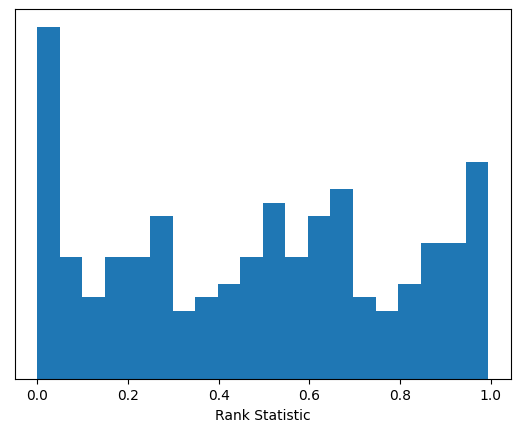

In [66]:
plt.hist(fractional_ranks, bins=20)
plt.xlabel("Rank Statistic")
plt.yticks([])
plt.show()

Looks like the rank histogram is not uniform. This likely indicates a miscalibrated model.

Another useful function is plotting the ECDF of the rank distribution. In a fully kitted out plotting library like [SBC](https://github.com/hyunjimoon/SBC) there's a parameter, $\gamma$, that needs to be tuned for determining the coverage. For now we'll just use a fixed gamma value of 0.2:

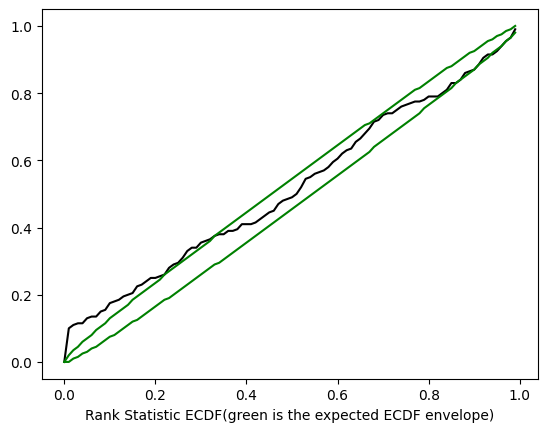

In [106]:
from scipy.stats import binom
def rank_ecdf(x):
    return np.sum(fractional_ranks < x) / 200

ecdf_xaxis = np.linspace(0, 0.99, 100)
gamma = 0.2


ecdf_lower =  binom.ppf(gamma / 2, 200, ecdf_xaxis) / 200
ecdf_upper = binom.ppf(1 - gamma / 2, 200, ecdf_xaxis) / 200

plt.plot(ecdf_xaxis, np.vectorize(rank_ecdf)(ecdf_xaxis), "-", ms=2, color="black")
plt.plot(ecdf_xaxis, ecdf_lower, "-", color="green")
plt.plot(ecdf_xaxis, ecdf_upper, "-", color="green")
plt.xlabel("Rank Statistic ECDF(green is the expected ECDF envelope)")
plt.show()

We can observe that indeed some portions of the ECDF lie outside the expected ECDF envelope, suggesting that the SBC results may hint miscalibration.